# Prediction of 2D ladybug trajectory with RNN

## Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

2025-04-25 00:24:59.344957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from math import sin, cos

## Setup parameters

In [3]:
sequence_len = 20
predict_len = 5
scale = 1
train_prop = 0.8
batch_size = 32
epochs = 5

In [4]:
max_t = 1000
delta_t = 0.02
features_len =2

## Generate dataset of ladybug trajectory

In [5]:
def ladybug_init(s=122):
    if s>0 :
        np.random.seed(s)
    param_x = [np.random.normal() for u in range(8)]
    param_y = [np.random.normal() for u in range(8)]
    return param_x, param_y

def ladybug_move(t,s=122):
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4],[ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init(s)
    
    x=ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*kx4)
    y=ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*ky4)

    return x,y

In [6]:
x,y=0,0
positions = []
for t in np.arange(0.0, max_t, delta_t):
    positions.append([x,y])
    x,y = ladybug_move(t, 42)

In [7]:
len(positions)

50000

In [8]:
n = len(positions)*scale
dataset = np.array(positions[:n])

In [9]:
dataset.shape

(50000, 2)

In [10]:
x_train = dataset[:int(n*train_prop)]
x_test = dataset[int(n*train_prop):]

In [11]:
x_train.shape

(40000, 2)

In [12]:
x_test.shape

(10000, 2)

## Normalize dataset

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
x_train.shape, x_test.shape

((40000, 2), (10000, 2))

In [16]:
dataset[:,0].shape

(50000,)

## Sample view of the dataset

In [17]:
def plot_2d_serie(data, figsize : tuple|list, save_as = None):
    plt.figure(figsize=figsize)

    x = data[:,0]
    y = data[:,1]
    plt.plot(x, y, color = "gray")
    if save_as!=None and isinstance(save_as, str):
        plt.savefig(save_as)

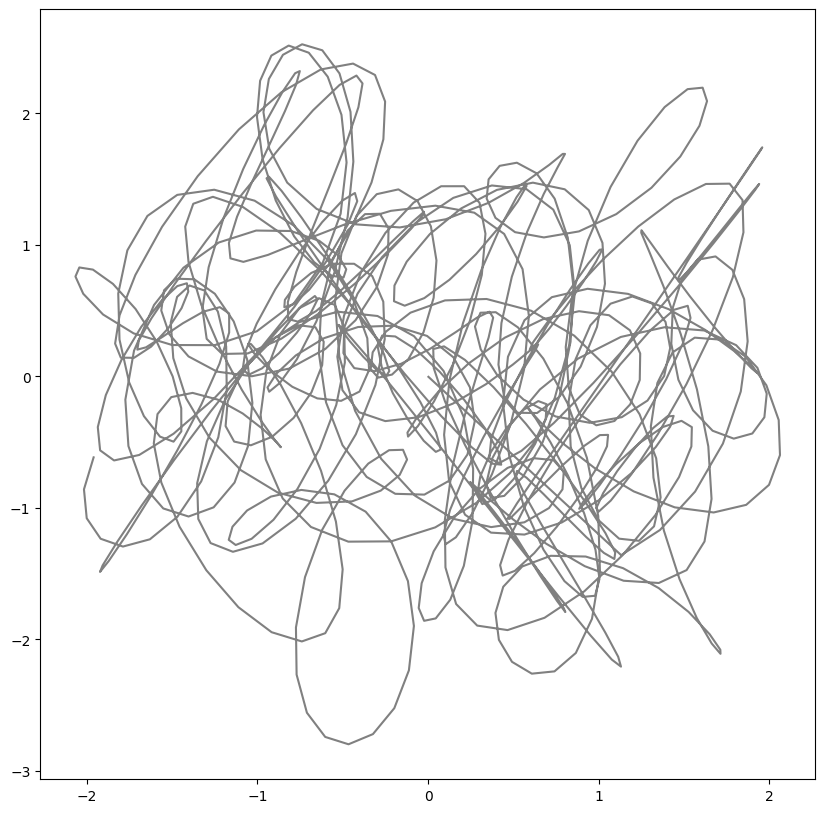

In [18]:
plot_2d_serie(x_train[:1000], figsize=(10,10), save_as='data.png')

In [19]:
def plot_2d_segment(sequence_segment, predict_segment, figsize:list|tuple, save_as=None):
    plt.figure(figsize=figsize)
    x_seq = sequence_segment[:,0]
    y_seq = sequence_segment[:,1]

    x_pred = predict_segment[:,0]
    y_pred = predict_segment[:,1]

    plt.plot(x_seq, y_seq, color='blue', marker = '.')
    plt.plot(x_pred, y_pred, color='red', marker = '.')

    if save_as!=None and isinstance(save_as, str):
        plt.savefig(save_as)

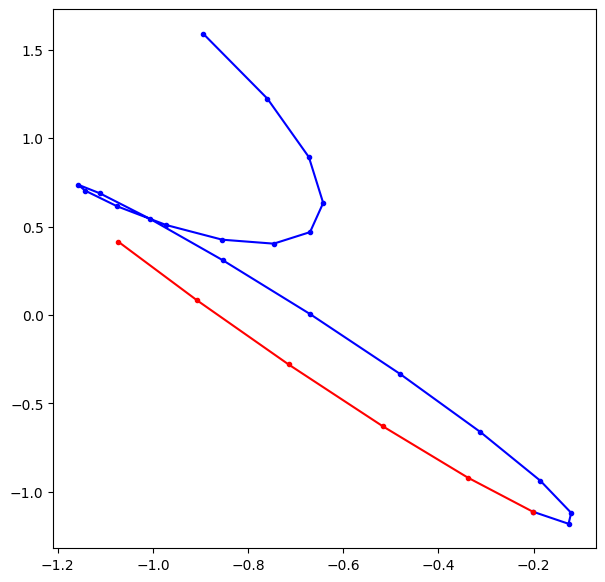

In [20]:
start_point = np.random.randint(0, x_test.shape[0]-(sequence_len+predict_len))
end_point = start_point+sequence_len
plot_2d_segment(x_test[start_point:end_point+1, :], x_test[end_point : end_point+1+predict_len, :], figsize=(7,7), save_as='sample_data.png')

## Prerare some data generator

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, x_test, length=sequence_len, batch_size=batch_size)

# RNN Model with GRU layer

## Create Model

In [23]:
model_rnn1 = tf.keras.models.Sequential()

In [24]:
model_rnn1.add(layers.Input(shape = (sequence_len, features_len)))
model_rnn1.add(layers.GRU(units=200, activation='relu', return_sequences=False))
model_rnn1.add(layers.Dense(features_len))

In [25]:
model_rnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 200)            │       122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,802 (479.70 KB)

 Trainable params: 122,802 (479.70 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [26]:
from tensorflow.keras import callbacks

In [27]:
best_model = '../data/checkpoint/model_rnn1.keras'
checkpoint = callbacks.ModelCheckpoint(best_model, save_best_only=True)

## Compilation

In [28]:
model_rnn1.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Fit

In [29]:
model_rnn1.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[checkpoint])

Epoch 1/5


/Users/macbookpro/miniforge3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - loss: 0.1051 - mae: 0.1817 - val_loss: 6.6993e-04 - val_mae: 0.0208
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 7.5821e-04 - mae: 0.0216 - val_loss: 7.3885e-04 - val_mae: 0.0223
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 47ms/step - loss: 9.5800e-04 - mae: 0.0231 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 0.0018 - val_mae: 0.0337
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - loss: 9.5090e-04 - mae: 0.0197 - val_loss: 2.4965e-04 - val_mae: 0.0120


In [30]:
model_rnn1.load_weights(best_model)

In [31]:
hist = model_rnn1.history.history

<function matplotlib.pyplot.show(close=None, block=None)>

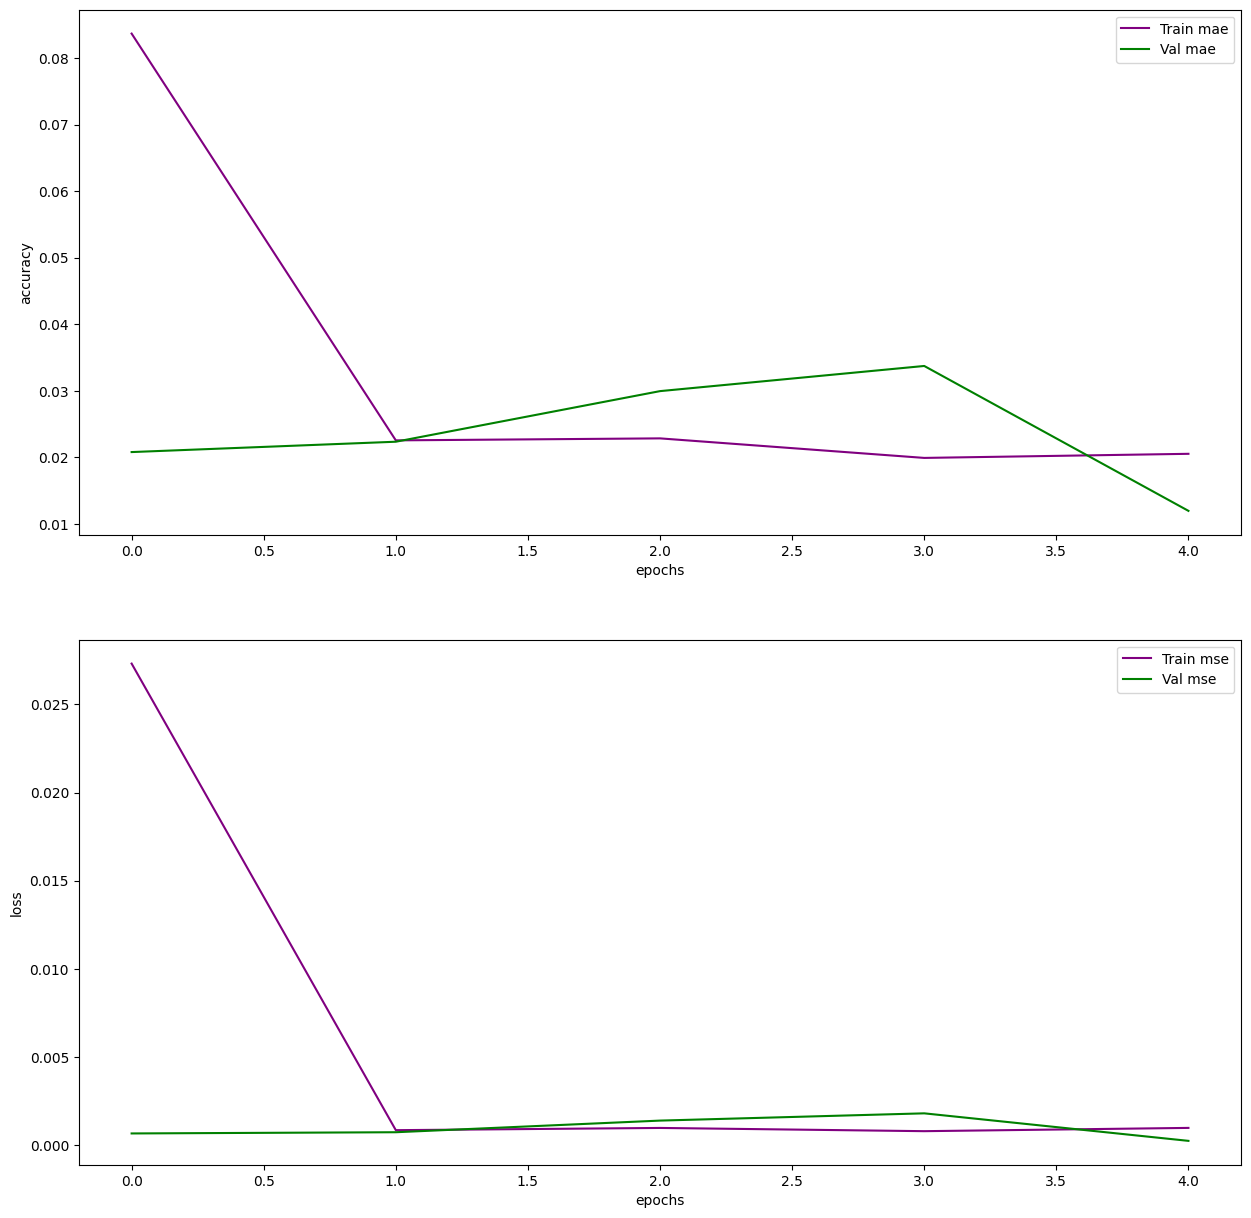

In [32]:
plt.figure(figsize=[15,15])

plt.subplot(2,1,1)
plt.plot(hist['mae'], label='Train mae', color='purple')
plt.plot(hist['val_mae'], label='Val mae', color='green')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.subplot(2,1,2)
plt.plot(hist['loss'], label='Train mse', color='purple')
plt.plot(hist['val_loss'], label='Val mse', color='green')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

plt.show

## Test

In [33]:
model_rnn1.predict(x_test[0:sequence_len].reshape(1,20,2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


array([[-0.07662993,  0.5068933 ]], dtype=float32)

In [34]:
def plot_2d_pred(true_seq, predict_seq, figsize:list|tuple, save_as=None):
    plt.figure(figsize=figsize)
    x_seq = true_seq[:,0]
    y_seq = true_seq[:,1]

    x_pred = predict_seq[:,0]
    y_pred = predict_seq[:,1]

    x_tmp = [x_seq[-(len(x_pred)+1)]]
    for x in x_pred:
        x_tmp.append(x)

    y_tmp = [y_seq[-(len(x_pred)+1)]]
    for y in y_pred:
        y_tmp.append(y)
        
    plt.plot(x_seq, y_seq, color='blue', marker = '.')
    plt.plot(x_tmp, y_tmp, color='red', marker = ',', ls = "--")

    if save_as!=None and isinstance(save_as, str):
        plt.savefig(save_as)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


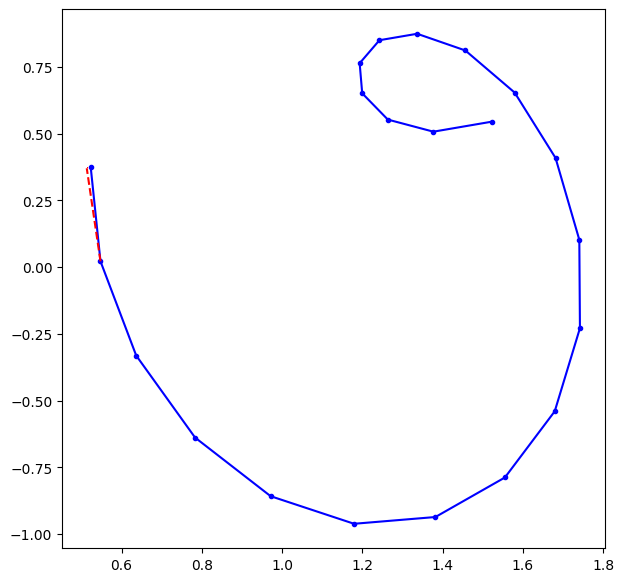

In [35]:
start_point = np.random.randint(0, x_test.shape[0]-(sequence_len+predict_len))
end_point = start_point+sequence_len

pred = model_rnn1.predict(x_test[start_point:end_point].reshape(1,20,2))
plot_2d_pred(x_test[start_point:end_point+1], pred, (7,7), save_as='single_prediction.png')

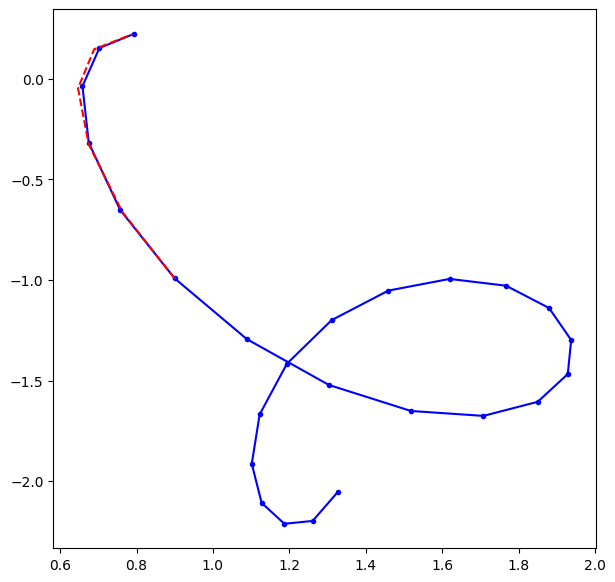

In [36]:
start_point = np.random.randint(0, x_test.shape[0]-(sequence_len+predict_len))
end_point = start_point+sequence_len

result = []
for start in range(0, predict_len):
    sequence = x_test[start_point+start:end_point+start]
    pred = model_rnn1.predict(sequence.reshape(1,20,2),verbose=False)
    result.append(pred)

result = np.array(result).reshape(predict_len, 2)
plot_2d_pred(x_test[start_point:end_point+predict_len], result, (7,7), save_as='multiple_pred.png')

# RNN Model with LSTM Layer